# Different Methods for Training Neural Functionals in Grad DFT

In this notebook, we will run through the different strategies that can be used to train a Neural functional in Grad DFT. Using $\text{H}_2$ and $\text{Na}_2$ as training molecules, we will study how a neural functional can generalize to calculating the total energy and density of $\text{Li}_2$. After following through this notebook, you should have a good idea how to use Grad DFT to train your own neural functionals. 

## Generating training/validation data and initial guesses

To run the forthcoming experiments, we need three things. 

1. Training data: this will be the data used to train our Neural functional. We will generate energy and densities from PySCF using the configuration interation singles and doubles (CISD) for $\text{H}_2$ and $\text{Na}_2$.

2. Validation data using the same method as above for $\text{Li}_2$

3. Initial guesses for densities and other quantities needed to prime Grad DFT. We'll use a Local Density Approximation (LDA) initial guess.

In [1]:
import pyscf

import jax.numpy as jnp
from jax import config
from jax.random import PRNGKey
config.update("jax_enable_x64", True)

from copy import deepcopy

import grad_dft as gd

seed = 1984 # Random seed used throughout this notebok for reproducibility reasons.
key = PRNGKey(seed)

/Users/pablo.casares/miniforge3/envs/graddft/lib/python3.10/site-packages/pyscf/dft/libxc.py:772: UserWarning: Since PySCF-2.3, B3LYP (and B3P86) are changed to the VWN-RPA variant, the same to the B3LYP functional in Gaussian and ORCA (issue 1480). To restore the VWN5 definition, you can put the setting "B3LYP_WITH_VWN5 = True" in pyscf_conf.py
  warnings.warn('Since PySCF-2.3, B3LYP (and B3P86) are changed to the VWN-RPA variant, '


Instructions for updating:
non-resource variables are not supported in the long term


In [2]:
# Training molecules. All experimental bond lengths taken from the Computational Chemistry Comparison and Benchmark DataBase
H2_bl = 0.7414
H2_mol =  pyscf.M(
        atom = 'H %.5f 0.0 0.0; H %.5f 0.0 0.0' % (-H2_bl/2, H2_bl/2),
        basis = '6-31G'
)

Na2_bl = 3.0789
Na2_mol =  pyscf.M(
        atom = 'Na %.5f 0.0 0.0; Na %.5f 0.0 0.0' % (-Na2_bl/2, Na2_bl/2),
        basis = '6-31G'
)

# Validation molecule
Li2_bl = 2.6730
Li2_mol =  pyscf.M(
        atom = 'Li %.5f 0.0 0.0; Li %.5f 0.0 0.0' % (-Li2_bl/2, Li2_bl/2),
        basis = '6-31G'
)

mols = [H2_mol, Na2_mol, Li2_mol]

energies = []
densities = []
init_guesses = []
for mol in mols:
    
    # CISD calculations used for training energies and densities
    mf = mol.UHF().run()
    ci = pyscf.ci.CISD(mf).run()
    
    # DFT calculations used for initial guesses for densities
    mf_dft = mol.UKS().run()
    grad_dft_mol = gd.molecule_from_pyscf(mf_dft)
    init_guesses.append(deepcopy(grad_dft_mol))
    
    # compute the rdm1 in the ao basis and pass to DFT object to compute CISD density
    # on same grid as DFT calculations. This works because we use the same AOs for DFT and CISD
    ci_rdm1 = ci.make_rdm1(ao_repr=True)
    dft_ci_rdm1 = grad_dft_mol.replace(rdm1=jnp.asarray(ci_rdm1))
    den_ci = dft_ci_rdm1.density()

    energies.append(ci.e_tot)
    densities.append(den_ci)

converged SCF energy = -1.1267339671166  <S^2> = 0  2S+1 = 1
E(UCISD) = -1.15168273210989  E_corr = -0.02494876499328594
converged SCF energy = -1.13268636851921  <S^2> = 2.220446e-16  2S+1 = 1
converged SCF energy = -323.681184308258  <S^2> = 4.602418e-09  2S+1 = 1
E(UCISD) = -323.7076326730954  E_corr = -0.0264483648369584
converged SCF energy = -322.869358891731  <S^2> = 4.0856207e-14  2S+1 = 1
converged SCF energy = -14.8657132324773  <S^2> = 1.6825652e-11  2S+1 = 1
E(UCISD) = -14.89345145295743  E_corr = -0.02773822048015379
converged SCF energy = -14.7175402132015  <S^2> = 1.4974688e-12  2S+1 = 1


## Defining a simple Neural functional

We now need a neural functional to train. We will go with the GGA version of the functional trained in the main article (DM21) with a strongly reduced number of layers and parameters. This makes our choice for $\mathbf{c}_{\boldsymbol{\theta}}[\rho](\mathbf{r})$ (fully defined in the main article). Although the energy densities $\mathbf{e}[\rho](r)$ can also be specified manually, Grad DFT ships with the DM21 energy densities (and many others), which we will just import.

In [3]:
from grad_dft.functional import canonicalize_inputs, dm21_coefficient_inputs, dm21_densities
from flax import linen as nn
from jax.nn import sigmoid, gelu
from functools import partial

squash_offset = 1e-4
layer_widths = [6] * 2

out_features = 2
sigmoid_scale_factor = 2.0
activation = gelu

def nn_coefficients(instance, rhoinputs, *_, **__):
    x = canonicalize_inputs(rhoinputs)  # Making sure dimensions are correct
    # Initial layer: log -> dense -> tanh
    x = jnp.log(jnp.abs(x) + squash_offset)  # squash_offset = 1e-4
    instance.sow("intermediates", "log", x)
    x = instance.dense(features=layer_widths[0])(x)  # features = 256
    instance.sow("intermediates", "initial_dense", x)
    x = jnp.tanh(x)
    instance.sow("intermediates", "norm", x)
    # 2 Residual blocks with 6-features dense layer and layer norm
    for features, i in zip(layer_widths, range(len(layer_widths))):  # layer_widths = [256]*6
        res = x
        x = instance.dense(features=features)(x)
        instance.sow("intermediates", "residual_dense_" + str(i), x)
        x = x + res  # nn.Dense + Residual connection
        instance.sow("intermediates", "residual_residual_" + str(i), x)
        x = instance.layer_norm()(x)  # + res # nn.LayerNorm
        instance.sow("intermediates", "residual_layernorm_" + str(i), x)
        x = activation(x)  # activation = jax.nn.gelu
        instance.sow("intermediates", "residual_elu_" + str(i), x)
    return instance.head(x, out_features, sigmoid_scale_factor)
        
functional = gd.NeuralFunctional(
    coefficients=nn_coefficients,
    coefficient_inputs=dm21_coefficient_inputs,
    energy_densities=partial(dm21_densities, functional_type="GGA"),
)

## Non self-consistent training

The simplest (and computationally cheapest) way to train a neural functional in Grad DFT is non-self consistently. In this scheme, Grad DFT is passed a density $\rho(\mathbf{r})$ which we approximate as the true ground state density for all values of the neural functional parameters $\boldsymbol{\theta}$. This is an acceptable approxmiation to make in cases where we can easily generate high quality densities.

Within this non-self consistent scheme, it is also only appropriate to train neural functionals using the scalar values of the truth energies. This is because, as stated before, the density is static upon changes to $\boldsymbol{\theta}$ (which, as you will see, can also be trained in the self-consistent case). The mean-squared error (MSE) energy loss is defined as:

$$
\mathcal{L^{\text{non-SC}}(\boldsymbol{\theta})} = \frac{1}{N}\sum_{i=0}^N (E_i^{\text{non-SC}}(\boldsymbol{\theta}) - E_i^{\text{truth}})^2
$$

where $N$ is the number of samples in the training set, $E_i^{\text{non-SC}}(\boldsymbol{\theta})$ is a non-self consistent evaluation of the total energy at the approximate ground state density $\rho_i(\mathbf{r})$ using a neural functional with parameters $\boldsymbol{\theta}$ and $E_i^{\text{truth}}$ is the corresponding high accuracy truth energy. The default loss functions in Grad DFT will also divide by the number of electrons in MSE losses so heavier molecules are less biased in training.

Let's write some code to train a neural functional in this way! We first define a function to be used throughout the rest of this notebook.

In [4]:
from optax import adam, apply_updates
from tqdm import tqdm
from jax import value_and_grad

def train_neural_functional(train_recipe: tuple, validate_recipe: tuple) -> None:
    r"""Minimize a Grad DFT loss function using 50 epochs of the Adam optimizer.

    Args:
        train_recipe (tuple):train_recipe (tuple): information regarding the loss, its arguments and the predictor.
        validate_recipe (tuple):train_recipe (tuple): the same information as train_recipe, but for the validation calculation.
    Returns:
        tuple: the training and validation loss history over the number of training epochs
    """
    
    loss_func, loss_args = train_recipe
    val_func, val_args = validate_recipe
    
    tr_params = functional.init(key, dm21_coefficient_inputs(loss_args[2][0]))
    loss_args[0] = tr_params
    val_args[0] = tr_params
    
    tx = adam(learning_rate=0.01, b1=0.9)
    opt_state = tx.init(tr_params)
    loss_and_grad = value_and_grad(loss_func)
    tr_loss_history = []
    val_loss_history = []
    for i in tqdm(range(50), desc="Training epoch"):
        tr_loss_value, grads = loss_and_grad(*loss_args)
        val_loss_value = val_func(*val_args)
        tr_loss_history.append(tr_loss_value)
        val_loss_history.append(val_loss_value)
        updates, opt_state = tx.update(grads, opt_state, tr_params)
        tr_params = apply_updates(tr_params, updates)
        loss_args[0] = tr_params
        val_args[0] = tr_params
        if (i + 1) % 5 == 0:
            print(f"At epoch {i+1} training loss = {tr_loss_value}, validation loss = {val_loss_value}")
    return tr_loss_history, val_loss_history
   

Now we define the settings to pass to `train_neural_functional` for non-self consistent training:

In [5]:
non_sc_train_recipe = (
    gd.mse_energy_loss, 
    [None, gd.non_scf_predictor(functional), init_guesses[0:2], energies[0:2], True]
)
non_sc_validate_recipe = (
    gd.mse_energy_loss, 
    [None, gd.non_scf_predictor(functional), [init_guesses[-1]], [energies[-1]], True]
)

In [6]:
tr_loss_his_nsc, val_loss_his_nsc = train_neural_functional(non_sc_train_recipe, non_sc_validate_recipe)

Training epoch:  10%|█         | 5/50 [00:13<01:22,  1.84s/it]

At epoch 5 training loss = 0.001927996853973431, validation loss = 0.003501704634718897


Training epoch:  20%|██        | 10/50 [00:19<00:51,  1.28s/it]

At epoch 10 training loss = 0.0008319135263938064, validation loss = 0.001657738892741021


Training epoch:  30%|███       | 15/50 [00:25<00:41,  1.19s/it]

At epoch 15 training loss = 0.0004687323629608845, validation loss = 0.0009604707546808235


Training epoch:  40%|████      | 20/50 [00:31<00:35,  1.19s/it]

At epoch 20 training loss = 0.00024946606983294916, validation loss = 0.000677267904351536


Training epoch:  50%|█████     | 25/50 [00:37<00:30,  1.22s/it]

At epoch 25 training loss = 0.0001225580268942625, validation loss = 0.0004521187182232138


Training epoch:  60%|██████    | 30/50 [00:43<00:23,  1.19s/it]

At epoch 30 training loss = 5.362569409362719e-05, validation loss = 0.00034442406913534417


Training epoch:  70%|███████   | 35/50 [00:49<00:18,  1.21s/it]

At epoch 35 training loss = 1.9061198198795605e-05, validation loss = 0.000249861256853164


Training epoch:  80%|████████  | 40/50 [00:55<00:11,  1.20s/it]

At epoch 40 training loss = 4.4784927927463145e-06, validation loss = 0.00020398412116591177


Training epoch:  90%|█████████ | 45/50 [01:01<00:06,  1.23s/it]

At epoch 45 training loss = 5.292065168507898e-07, validation loss = 0.00015977298685814333


Training epoch: 100%|██████████| 50/50 [01:07<00:00,  1.35s/it]

At epoch 50 training loss = 8.930386384140963e-07, validation loss = 0.00014868584052716525


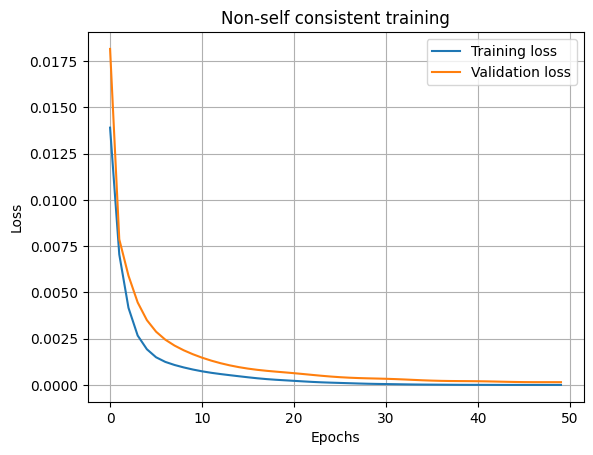

In [7]:
import matplotlib.pyplot as plt

plt.plot(tr_loss_his_nsc, label="Training loss")
plt.plot(val_loss_his_nsc, label="Validation loss")
plt.ylabel("Loss")
plt.xlabel("Epochs")
plt.title("Non-self consistent training")
plt.grid()
plt.legend()

## Self consistent training

### Energy loss

In the non-self consistent case above, the density $\rho(\mathbf{r})$ is not guaranteed to be a good approximation for the ground-state density of our neural functional. We can, however, enforce this condition at all values of $\boldsymbol{\theta}$ by performing a differentiable self consistent field (SCF) calculation. The density itself is now variable. This is more computationally demmanding than before, but is more reliable in many cases. The same loss function we used before can be used here with the small difference that energies are now calculated self-consistently

$$
\mathcal{L}^{\text{SCF}(\boldsymbol{\theta})}_E = \frac{1}{N}\sum_{i=0}^N (E_i^{\text{SCF}}(\boldsymbol{\theta}) - E_i^{\text{truth}})^2.
$$

We have a few different versions of the SCF loop implemented in Grad DFT, but an efficient one is Direct inversion of the iterative subspace (DIIS). This is also compatible with JIT compilation giving us performance boosts.

Let's do it.

In [8]:
sc_en_train_recipe = (
    gd.mse_energy_loss, 
    [None, gd.diff_scf_loop(functional, cycles=5), init_guesses[0:2], energies[0:2], True]
)
sc_en_validate_recipe = (
    gd.mse_energy_loss, 
    [None, gd.diff_scf_loop(functional, cycles=5), [init_guesses[-1]], [energies[-1]], True]
)

In [9]:
tr_loss_his_sc_en, val_loss_his_sc_en = train_neural_functional(sc_en_train_recipe, sc_en_validate_recipe)

Training epoch:  10%|█         | 5/50 [01:00<06:46,  9.02s/it]

At epoch 5 training loss = 0.009698051233456658, validation loss = 0.006091744942511641


Training epoch:  20%|██        | 10/50 [01:31<04:19,  6.49s/it]

At epoch 10 training loss = 0.008316469217256562, validation loss = 0.003810195526801274


Training epoch:  30%|███       | 15/50 [01:59<03:21,  5.76s/it]

At epoch 15 training loss = 0.006785388363074792, validation loss = 0.004228686398297427


Training epoch:  40%|████      | 20/50 [02:27<02:45,  5.51s/it]

At epoch 20 training loss = 0.005317314480224619, validation loss = 0.0031933665964728962


Training epoch:  50%|█████     | 25/50 [02:58<02:28,  5.94s/it]

At epoch 25 training loss = 0.004142344559525419, validation loss = 0.002798681548446808


Training epoch:  60%|██████    | 30/50 [03:26<01:49,  5.47s/it]

At epoch 30 training loss = 0.0032131594041329274, validation loss = 0.0028407097337378997


Training epoch:  70%|███████   | 35/50 [04:04<01:51,  7.42s/it]

At epoch 35 training loss = 0.0024781591296485824, validation loss = 0.002169129177841567


Training epoch:  80%|████████  | 40/50 [04:48<01:24,  8.48s/it]

At epoch 40 training loss = 0.0019146567055772898, validation loss = 0.0022605704534637847


Training epoch:  90%|█████████ | 45/50 [05:29<00:41,  8.20s/it]

At epoch 45 training loss = 0.0014879034463645454, validation loss = 0.0018594541302677523


Training epoch: 100%|██████████| 50/50 [06:04<00:00,  7.29s/it]

At epoch 50 training loss = 0.0011648050164508, validation loss = 0.0018914251383776053


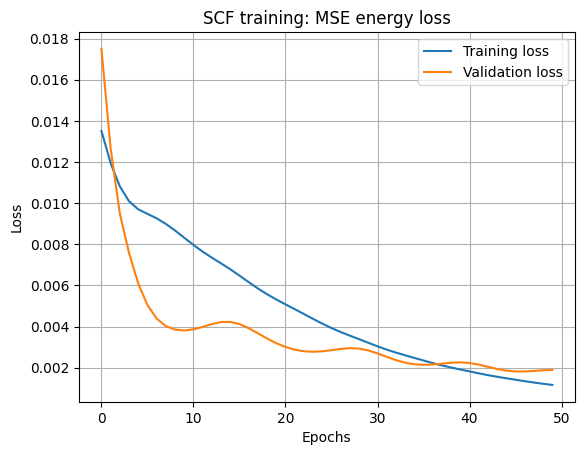

In [10]:
plt.plot(tr_loss_his_sc_en, label="Training loss")
plt.plot(val_loss_his_sc_en, label="Validation loss")
plt.ylabel("Loss")
plt.xlabel("Epochs")
plt.title("SCF training: MSE energy loss")
plt.grid()
plt.legend()

In this particular case, not much advantage was gained from training self consistently as compared with the non-self consistent case. Indeed, as we will see from the values obtained from the next loss function, the error in the density is very small already. This of course is not guaranteed (and is probably not) the case for more strongly correlated materials where our DFT density guess is poor. 

### Density loss

In self-consistent DFT, we can predict the density as well as the energy. This means that the density can also be trained. In Grad DFT, we use the squared electron error integral to define a density loss

$$
\mathcal{L}^{\text{SCF}}_{\rho}(\boldsymbol{\theta}) = \frac{1}{N}\sum_{i=0}^N \int \left[ \rho_{i, \mathbf{\theta}}^{\text{SCF}}(\mathbf{r}) - \rho_i^{\text{truth}}(\mathbf{r}) \right] ^2 d \mathbf{r}.
$$

where, as before, we also normalize by the number of electrons by default. Let's train with this loss.

In [11]:
sc_den_train_recipe = (
    gd.mse_density_loss, 
    [None, gd.diff_scf_loop(functional, cycles=5), init_guesses[0:2], densities[0:2], True]
)
sc_den_validate_recipe = (
    gd.mse_density_loss, 
    [None, gd.diff_scf_loop(functional, cycles=5), [init_guesses[-1]], [densities[-1]], True]
)

In [12]:
tr_loss_his_sc_den, val_loss_his_sc_den = train_neural_functional(sc_den_train_recipe, sc_den_validate_recipe)

Training epoch:  10%|█         | 5/50 [00:54<06:04,  8.11s/it]

At epoch 5 training loss = 6.638889218673409e-06, validation loss = 4.482912023889014e-07


Training epoch:  20%|██        | 10/50 [01:29<04:40,  7.02s/it]

At epoch 10 training loss = 9.131984800634856e-07, validation loss = 2.4397380982344497e-07


Training epoch:  30%|███       | 15/50 [02:01<03:51,  6.60s/it]

At epoch 15 training loss = 8.886014950407089e-07, validation loss = 1.961035306414856e-07


Training epoch:  40%|████      | 20/50 [02:34<03:20,  6.68s/it]

At epoch 20 training loss = 8.04188269650195e-07, validation loss = 1.6936179811519716e-07


Training epoch:  50%|█████     | 25/50 [03:07<02:36,  6.27s/it]

At epoch 25 training loss = 7.34906963651581e-07, validation loss = 1.544473793493267e-07


Training epoch:  60%|██████    | 30/50 [03:36<02:01,  6.08s/it]

At epoch 30 training loss = 7.238039607917981e-07, validation loss = 1.4561792301300512e-07


Training epoch:  70%|███████   | 35/50 [04:05<01:23,  5.56s/it]

At epoch 35 training loss = 6.522355673112391e-07, validation loss = 1.4020793285309037e-07


Training epoch:  80%|████████  | 40/50 [04:34<01:02,  6.21s/it]

At epoch 40 training loss = 6.212794494613547e-07, validation loss = 1.3691290696035244e-07


Training epoch:  90%|█████████ | 45/50 [05:04<00:28,  5.77s/it]

At epoch 45 training loss = 6.170907544941632e-07, validation loss = 1.3482406173560656e-07


Training epoch: 100%|██████████| 50/50 [05:42<00:00,  6.85s/it]

At epoch 50 training loss = 5.881899842629418e-07, validation loss = 1.3341387775022726e-07


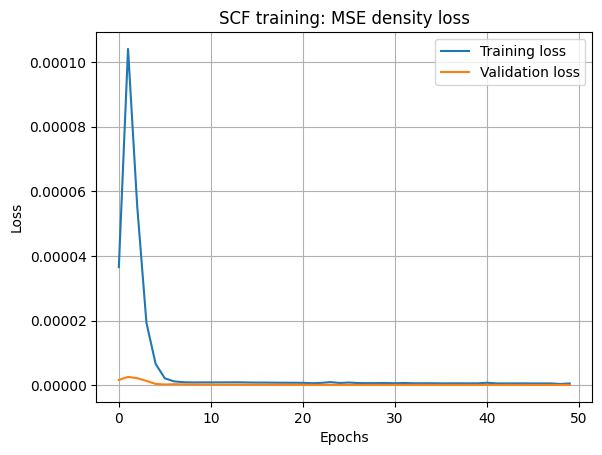

In [13]:
plt.plot(tr_loss_his_sc_den, label="Training loss")
plt.plot(val_loss_his_sc_den, label="Validation loss")
plt.ylabel("Loss")
plt.xlabel("Epochs")
plt.title("SCF training: MSE density loss")
plt.grid()
plt.legend()

as we already alluded to, it appears that in this situation the density error was already quite low for a randomly initialized $\boldsymbol{\theta}$. Interestingly though, Grad DFT was still able to improve this error.

### Joint energy and density loss

Last but not least, the most general way of training a neural functional in Grad DFT, where the data is available, is to train using the energy and density. That is, we have

$$
L_{E, \rho}^{SCF}(\boldsymbol{\theta}) = a \mathcal{L}^{\text{SCF}(\boldsymbol{\theta})}_E + b\mathcal{L}^{\text{SCF}}_{\rho}(\boldsymbol{\theta})
$$

where $a$ and $b$ are real valued positive numbers used to weight the loss contribtion from energies and densities, respectively. Because we observed a very low density error in the previous loss function, we will set $b=1000$ in the below to get energy and los contributions on the same order of magnitude.



In [14]:
sc_en_den_train_recipe = (
    gd.mse_energy_and_density_loss, 
    [None, gd.diff_scf_loop(functional, cycles=5), init_guesses[0:2], densities[0:2], energies[0:2], 1e3, 1.0, True]
)
sc_en_den_validate_recipe = (
    gd.mse_energy_and_density_loss,
    [None, gd.diff_scf_loop(functional, cycles=5), [init_guesses[-1]], [densities[-1]], [energies[-1]], 1e3, 1.0, True]
)

In [15]:
tr_loss_his_sc_en_den, val_loss_his_sc_en_den = train_neural_functional(sc_en_den_train_recipe, sc_en_den_validate_recipe)

Training epoch:  10%|█         | 5/50 [00:51<05:39,  7.55s/it]

At epoch 5 training loss = 0.022349826285910236, validation loss = 0.02025831915909754


Training epoch:  20%|██        | 10/50 [01:36<06:21,  9.55s/it]

At epoch 10 training loss = 0.021978431146163636, validation loss = 0.019833201342988615


Training epoch:  30%|███       | 15/50 [02:15<04:47,  8.21s/it]

At epoch 15 training loss = 0.020861135927170465, validation loss = 0.018050281440868055


Training epoch:  40%|████      | 20/50 [03:17<06:16, 12.55s/it]

At epoch 20 training loss = 0.019771357954437237, validation loss = 0.016217135550924182


Training epoch:  50%|█████     | 25/50 [03:49<03:08,  7.54s/it]

At epoch 25 training loss = 0.01897271888574522, validation loss = 0.01462438699106922


Training epoch:  60%|██████    | 30/50 [04:24<02:18,  6.94s/it]

At epoch 30 training loss = 0.018368044123784677, validation loss = 0.01331967136312717


Training epoch:  70%|███████   | 35/50 [04:57<01:42,  6.85s/it]

At epoch 35 training loss = 0.017904515831793064, validation loss = 0.012269764976244992


Training epoch:  80%|████████  | 40/50 [05:28<01:02,  6.22s/it]

At epoch 40 training loss = 0.017542076999245735, validation loss = 0.011446721767399493


Training epoch:  90%|█████████ | 45/50 [06:00<00:32,  6.50s/it]

At epoch 45 training loss = 0.01722774750497955, validation loss = 0.010781243879610042


Training epoch: 100%|██████████| 50/50 [06:30<00:00,  7.80s/it]

At epoch 50 training loss = 0.01694431598322883, validation loss = 0.01023134802998395


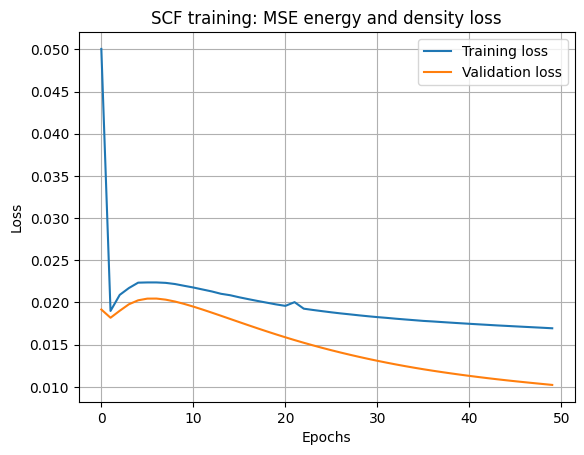

In [16]:
plt.plot(tr_loss_his_sc_en_den, label="Training loss")
plt.plot(val_loss_his_sc_en_den, label="Validation loss")
plt.ylabel("Loss")
plt.xlabel("Epochs")
plt.title("SCF training: MSE energy and density loss")
plt.grid()
plt.legend()

You now know how to train a neural functional in Grad DFT with a number of approaches. This notebook was, however, not exhaustive, so please do take a look through the `advanced_scripts` folder for further scripts with advanced training options. 

<style>
@media (prefers-color-scheme: dark) {
    .light-mode-image {
        display: none;
    }
}

@media (prefers-color-scheme: light) {
    .dark-mode-image {
        display: none;
    }
}
</style>